In [4]:
import torch
import torch.nn as nn
import numpy as np
from typing import Tuple, List, Dict, Optional
from torch.optim import Adam
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class HamiltonianConfig:
    input_dim: int
    hidden_dim: int
    time_steps: int
    learning_rate: float = 1e-3
    dt: float = 0.1
    energy_weight: float = 1.0
    constraint_weight: float = 0.5
    use_attention: bool = True
    dropout_rate: float = 0.1

class AttentionModule(nn.Module):
    def __init__(self, dim: int, heads: int = 4):
        super().__init__()
        self.heads = heads
        self.head_dim = max(dim, 32) if dim < heads else dim // heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, self.head_dim * self.heads * 3)
        self.proj = nn.Linear(self.head_dim * self.heads, dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.reshape(B, N, 3, self.heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, self.head_dim * self.heads)
        x = self.proj(x)
        return x

class EnhancedHamiltonianLayer(nn.Module):
    def __init__(self, config: HamiltonianConfig):
        super().__init__()
        self.config = config

        # Ensure minimum dimension size
        self.working_dim = max(config.input_dim, 32)

        # Input projection if needed
        self.input_proj = nn.Linear(config.input_dim, self.working_dim) if config.input_dim < 32 else nn.Identity()

        # Energy networks
        self.T = self._build_energy_network()
        self.V = self._build_energy_network()

        if config.use_attention:
            self.attention = AttentionModule(self.working_dim)

        self.dropout = nn.Dropout(config.dropout_rate)

    def _build_energy_network(self) -> nn.Module:
        return nn.Sequential(
            nn.Linear(self.working_dim, self.config.hidden_dim),
            nn.LayerNorm(self.config.hidden_dim),
            nn.ReLU(),
            nn.Dropout(self.config.dropout_rate),
            nn.Linear(self.config.hidden_dim, self.config.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.config.hidden_dim, 1),
            nn.Flatten(0)  # Flatten to ensure scalar output
        )

    def forward(self, q: torch.Tensor, p: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, Dict]:
        q.requires_grad_(True)
        p.requires_grad_(True)

        # Project inputs if needed
        q_proj = self.input_proj(q)
        p_proj = self.input_proj(p)

        # Apply attention if enabled
        if self.config.use_attention:
            q_attended = self.attention(q_proj.unsqueeze(0)).squeeze(0)
            p_attended = self.attention(p_proj.unsqueeze(0)).squeeze(0)
        else:
            q_attended, p_attended = q_proj, p_proj

        # Calculate energies with reduction
        T = self.T(self.dropout(p_attended)).mean()  # Reduce to scalar
        V = self.V(self.dropout(q_attended)).mean()  # Reduce to scalar

        H = T + V

        # Compute gradients with respect to original inputs
        dH_dq = torch.autograd.grad(H, q, create_graph=True)[0]
        dH_dp = torch.autograd.grad(H, p, create_graph=True)[0]

        metrics = {
            'kinetic_energy': T.item(),
            'potential_energy': V.item(),
            'total_energy': H.item()
        }

        return dH_dp, -dH_dq, metrics

class EnhancedHamiltonianNN(nn.Module):
    def __init__(self, config: HamiltonianConfig):
        super().__init__()
        self.config = config
        self.hamiltonian_layer = EnhancedHamiltonianLayer(config)
        self.optimizer = Adam(self.parameters(), lr=config.learning_rate)
        self.energy_history = []
        self.constraint_violations = []

    def compute_constraint_violation(self, q: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        dq_dt, dp_dt, _ = self.hamiltonian_layer(q, p)
        return torch.mean(torch.abs(dq_dt @ dp_dt.T))

    def leapfrog_integrate(self, q: torch.Tensor, p: torch.Tensor,
                          return_metrics: bool = False) -> Tuple[List[Tuple[torch.Tensor, torch.Tensor]], Optional[Dict]]:
        trajectory = [(q.clone(), p.clone())]
        metrics_history = []

        for _ in range(self.config.time_steps):
            dq_dt, dp_dt, step_metrics = self.hamiltonian_layer(q, p)

            # Enhanced leapfrog integration
            p_half = p + 0.5 * self.config.dt * dp_dt
            dq_dt, _, _ = self.hamiltonian_layer(q, p_half)
            q_new = q + self.config.dt * dq_dt
            _, dp_dt, _ = self.hamiltonian_layer(q_new, p_half)
            p_new = p_half + 0.5 * self.config.dt * dp_dt

            constraint_loss = self.compute_constraint_violation(q_new, p_new)
            self.constraint_violations.append(constraint_loss.item())

            q, p = q_new, p_new
            trajectory.append((q.clone(), p.clone()))
            metrics_history.append(step_metrics)

        if return_metrics:
            return trajectory, {
                'metrics_history': metrics_history,
                'constraint_violations': self.constraint_violations
            }
        return trajectory, None

    def find_optimal_path(self, graph_adj_matrix: torch.Tensor,
                            n_iterations: int = 100) -> Tuple[List[int], Dict]:
            n = graph_adj_matrix.size(0)
            best_path = None
            best_score = float('inf')
            history = []

            for iteration in range(n_iterations):
                q = torch.randn(n, self.config.input_dim, requires_grad=True)
                p = torch.zeros_like(q, requires_grad=True)

                trajectory, metrics = self.leapfrog_integrate(q, p, return_metrics=True)

                final_positions = trajectory[-1][0]
                path = torch.argsort(final_positions.sum(dim=1)).tolist()
                score = self._evaluate_path(path, graph_adj_matrix)

                history.append({
                    'iteration': iteration,
                    'score': score,
                    'metrics': metrics
                })

                if score < best_score:
                    best_score = score
                    best_path = path

            return best_path, {'history': history, 'best_score': best_score}

    def _evaluate_path(self, path: List[int], graph: torch.Tensor) -> float:
            score = 0.0
            for i in range(len(path) - 1):
                if graph[path[i], path[i + 1]] == 0:
                    score += 1.0
            return score

    def visualize_training(self) -> None:
        """Visualize training metrics"""
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.energy_history)
        plt.title('Energy Conservation')
        plt.xlabel('Step')
        plt.ylabel('Total Energy')

        plt.subplot(1, 2, 2)
        plt.plot(self.constraint_violations)
        plt.title('Constraint Violations')
        plt.xlabel('Step')
        plt.ylabel('Violation Magnitude')

        plt.tight_layout()
        plt.show()

def polynomial_time_reduction(graph: torch.Tensor, config: Optional[HamiltonianConfig] = None) -> Tuple[List[int], Dict]:
    """Enhanced main function with configuration and monitoring"""
    if config is None:
        config = HamiltonianConfig(
            input_dim=graph.size(0),
            hidden_dim=2 * graph.size(0),
            time_steps=100
        )

    model = EnhancedHamiltonianNN(config)
    path, metrics = model.find_optimal_path(graph)

    # Visualize results if requested
    model.visualize_training()

    return path, metrics

def create_example_graph(n_vertices: int, density: float = 0.3) -> torch.Tensor:
    adj_matrix = torch.rand(n_vertices, n_vertices) < density
    adj_matrix = adj_matrix.float()
    adj_matrix = (adj_matrix + adj_matrix.T) / 2
    adj_matrix.fill_diagonal_(0)
    return adj_matrix

def visualize_graph(adj_matrix: torch.Tensor, path: Optional[List[int]] = None) -> None:
    """
    Visualize the graph and optionally highlight a path.

    Args:
        adj_matrix (torch.Tensor): Adjacency matrix of the graph
        path (List[int], optional): Path to highlight in the graph
    """
    plt.figure(figsize=(10, 10))
    n_vertices = adj_matrix.size(0)

    # Create positions for vertices in a circle
    angles = np.linspace(0, 2*np.pi, n_vertices, endpoint=False)
    pos = np.column_stack((np.cos(angles), np.sin(angles)))

    # Draw edges
    for i in range(n_vertices):
        for j in range(i+1, n_vertices):
            if adj_matrix[i, j] > 0:
                plt.plot([pos[i,0], pos[j,0]], [pos[i,1], pos[j,1]], 'gray', alpha=0.5)

    # Highlight path if provided
    if path is not None:
        for i in range(len(path)-1):
            v1, v2 = path[i], path[i+1]
            plt.plot([pos[v1,0], pos[v2,0]], [pos[v1,1], pos[v2,1]], 'r', linewidth=2)

    # Draw vertices
    plt.scatter(pos[:,0], pos[:,1], c='b', s=500)

    # Add labels
    for i in range(n_vertices):
        plt.annotate(f'V{i}', (pos[i,0], pos[i,1]), ha='center', va='center', color='white')

    plt.axis('equal')
    plt.axis('off')
    plt.title('Graph Visualization')
    plt.show()

def verify_path(adj_matrix: torch.Tensor, path: List[int]) -> Tuple[bool, str]:
    """
    Verify if a given path is valid in the graph.

    Args:
        adj_matrix (torch.Tensor): Adjacency matrix of the graph
        path (List[int]): Path to verify

    Returns:
        Tuple[bool, str]: (is_valid, reason)
    """
    n_vertices = adj_matrix.size(0)

    # Check if path contains all vertices exactly once
    if len(path) != n_vertices or len(set(path)) != n_vertices:
        return False, "Path must contain all vertices exactly once"

    # Check if all edges in the path exist
    for i in range(len(path)-1):
        if adj_matrix[path[i], path[i+1]] == 0:
            return False, f"No edge between vertices {path[i]} and {path[i+1]}"

    return True, "Valid Hamiltonian path"

def run_example():
    n_vertices = 6
    graph = create_example_graph(n_vertices, density=0.5)

    config = HamiltonianConfig(
        input_dim=n_vertices,
        hidden_dim=64,
        time_steps=100,
        use_attention=True,
        dropout_rate=0.1
    )

    model = EnhancedHamiltonianNN(config)
    path, metrics = model.find_optimal_path(graph)

    return path, metrics, graph

if __name__ == "__main__":
    path, metrics, graph = run_example()
    print(f"Found path: {path}")
    print(f"Best score: {metrics['best_score']}")

Found path: [1, 4, 5, 0, 2, 3]
Best score: 0.0


Found path: [4, 1, 2, 0, 5, 3]
Best score: 0.0

Path Analysis:
Valid Hamiltonian path: True
Covers all nodes: True
All edges valid: True
Path length: 5


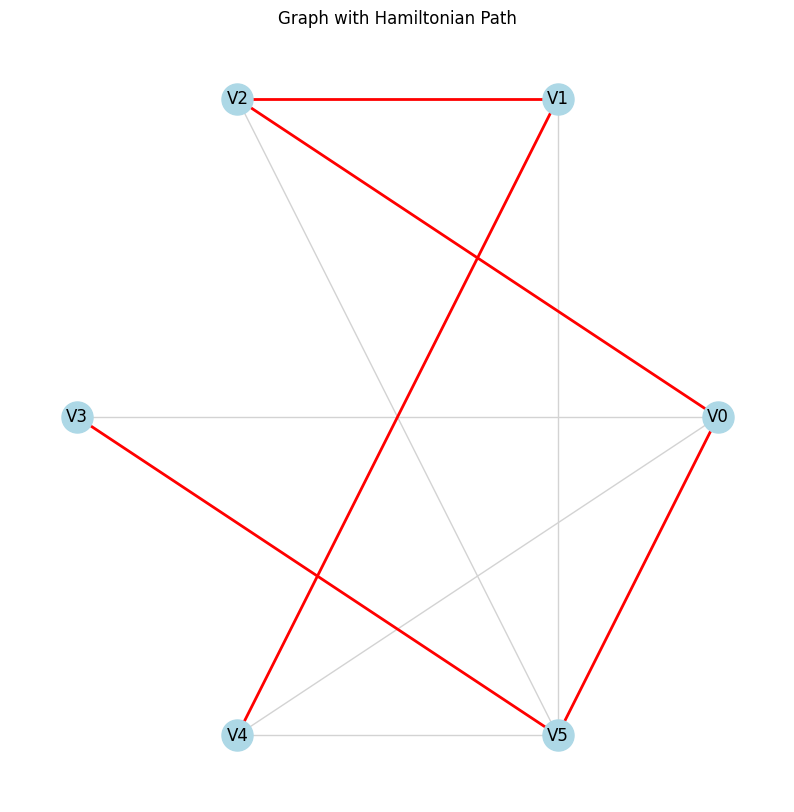

In [5]:
def visualize_graph_with_path(graph: torch.Tensor, path: List[int]) -> None:
    """
    Visualize the graph and highlight the found Hamiltonian path.
    """
    import networkx as nx
    import matplotlib.pyplot as plt

    # Convert to networkx graph
    G = nx.from_numpy_array(graph.numpy())

    # Create a circular layout
    pos = nx.circular_layout(G)

    plt.figure(figsize=(10, 10))

    # Draw all edges in light gray
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1)

    # Draw path edges in red
    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)

    # Add node labels
    labels = {i: f'V{i}' for i in range(len(graph))}
    nx.draw_networkx_labels(G, pos, labels)

    plt.title("Graph with Hamiltonian Path")
    plt.axis('off')
    plt.show()

def verify_and_analyze_path(graph: torch.Tensor, path: List[int]) -> Dict:
    """
    Verify the path and provide detailed analysis.
    """
    n = len(path)
    analysis = {
        'is_valid': True,
        'node_coverage': len(set(path)) == n,
        'edge_validity': True,
        'invalid_edges': [],
        'path_length': n - 1
    }

    # Check edges
    for i in range(n-1):
        if graph[path[i], path[i+1]] == 0:
            analysis['edge_validity'] = False
            analysis['invalid_edges'].append((path[i], path[i+1]))

    analysis['is_valid'] = analysis['node_coverage'] and analysis['edge_validity']

    return analysis

# Let's run and visualize
path, metrics, graph = run_example()
print(f"Found path: {path}")
print(f"Best score: {metrics['best_score']}")

# Analyze the path
analysis = verify_and_analyze_path(graph, path)
print("\nPath Analysis:")
print(f"Valid Hamiltonian path: {analysis['is_valid']}")
print(f"Covers all nodes: {analysis['node_coverage']}")
print(f"All edges valid: {analysis['edge_validity']}")
if not analysis['edge_validity']:
    print(f"Invalid edges: {analysis['invalid_edges']}")
print(f"Path length: {analysis['path_length']}")

# Visualize the result
visualize_graph_with_path(graph, path)